In [1]:
import os
import datetime

import numpy as np
import scipy
import fiona
import statistics
import math

import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, shape, mapping, Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
from matplotlib import colors, cm, style
import matplotlib.patches as mpatches
from descartes import PolygonPatch

import osmnx as ox
import networkx as nx

In [2]:
from my_osm import get_osm_data
from my_isochrones import get_isochrones
from my_metrics import compute_edge_betweenness

In [3]:
style.use('seaborn-white')
output_folder = 'data'
osm_crs = 'EPSG:3857'

# Parameters

In [4]:
# Place                                Country              CRS
# Amsterdam | Rotterdam | The Hague    (The Netherlands)    EPSG:28992
# Madrid    | Barcelona | Valencia     (Spain)              EPSG:25830
# Stockholm | Goteborg  | Malmo        (Sweden)             EPSG:3006 ???
# Milano                               (Italy)              EPSG:6875 ???
# Ljubljana                            (Slovenia)           EPSG:8687 ???

place_name = 'Utrecht'

In [5]:
if place_name == 'Milano':
    local_crs = 'EPSG:6875'    
elif place_name == 'Ljubljana':
    local_crs = 'EPSG:8687'
elif place_name == 'Utrecht':
    local_crs = 'EPSG:28992'

In [6]:
buffer = 300

# Load data

In [7]:
if place_name == 'Milano':
    xmin = 1022678.517
    ymin = 5695916.600
    xmax = 1027342.347
    ymax = 5698126.489
    
elif place_name == 'Ljubljana':
    xmin =  1612551.082
    ymin =  5787620.135
    xmax =  1617214.912
    ymax =  5789830.024
    
elif place_name == 'Utrecht':
    xmin =  564607.450
    ymin =  6815369.636
    xmax =  569271.280
    ymax =  6817579.525

In [8]:
pointList = [Point(xmin, ymin), Point(xmax, ymin), Point(xmax, ymax), Point(xmin, ymax), Point(xmin, ymin)]
bbox_shape = Polygon([[p.x, p.y] for p in pointList])

place = gpd.GeoDataFrame(index=[0], crs='epsg:3857', geometry=[bbox_shape])
place = place.to_crs(local_crs)

In [12]:
extent = place.buffer(buffer, join_style=2)
if len(extent) > 1:
    extent_shape = MultiPolygon([shape(part) for part in extent.to_crs('EPSG:4326')])     
else:
    extent_shape = extent.to_crs('EPSG:4326')[0]

### Play spaces

In [13]:
# playgrounds sometimes lie on school premises
# schoolyards are a rarely used tag, in used, but not formally approved 
# (e.g., in our case study cities, appearing only once, in Ljubljana, but with access=private)
# in practice, school premises are tagged as amenity=school, but this tag includes many other types of schools as well
# with the school itself being building=school
# often, when there are play facilities, these are tagged as playground
# we try to find some playgrounds on school premises, and extend it with places tagged as playgrounds, but these are few generally, or private
school_filter = (f'["amenity"~"school"]')
schools = gpd.clip(get_osm_data(school_filter, extent, 'convexhull'), extent)
schools.geometry = schools.buffer(10)
# we are interested in what playgrounds lie on or directly adjacent to schools (i.e. within 10m)

#### playgrounds

In [14]:
playgrounds_filter = (f'["leisure"~"playground"]["access"!="private"]')
playgrounds = get_osm_data(playgrounds_filter, extent, 'convexhull')
if len(playgrounds):
    playgrounds = gpd.clip(playgrounds, extent)

Response <Response [504]>
Waiting 30sec, and trying again max 4 more times


In [15]:
# drop those on school premises
playgrounds = playgrounds.sjoin(schools[['geometry']], how='left')
playgrounds = playgrounds[playgrounds['index_right'].isna()]
playgrounds = playgrounds.drop(columns=['index_right'])

#### schoolyards

In [16]:
schoolyards_filter = (f'["leisure"~"schoolyard"]["access"!="private"]')
schoolyards = get_osm_data(schoolyards_filter, extent, 'convexhull')
if len(schoolyards):
    schoolyards = gpd.clip(schoolyards, extent)

In [17]:
# playgrounds or pitches on school premises
potential_schoolyards_filter = (f'["leisure"~"playground|pitch"]["access"!="private"]')
potential_schoolyards = get_osm_data(potential_schoolyards_filter, extent, 'convexhull')
if len(potential_schoolyards):
    potential_schoolyards = gpd.clip(potential_schoolyards, extent)
if len(potential_schoolyards):
    potential_schoolyards = gpd.clip(potential_schoolyards, schools)

In [18]:
schoolyards = schoolyards.append(potential_schoolyards)

<AxesSubplot:>

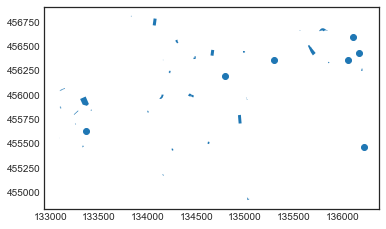

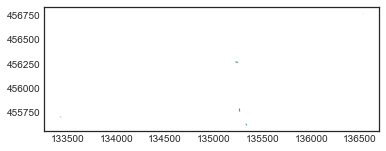

In [19]:
playgrounds.plot()
schoolyards.plot()

#### natural, type-based

In [20]:
def greenspace_filter(gdf, local_crs,
                      threshold=0, place=None, min_area=None, max_area=None, G=None):
    """
    gdf = geoseries of greenery polygons (e.g. greenery.geometry)
    return = a union of filtered polygons
    [optional] threshold to merge spaces in proximity (in meters)
    [optional] place geoseries of total area geometries (e.g. place_gdf.geometry)
    [optional] minimum area for greenspace filter, default value set
    [optional] graph which greenspace should intersect nodes and edges of
    """
    
    filtered = gdf.copy()
    
    # only polygons, no points or lines
    filtered = filtered[(filtered.geom_type == 'Polygon')|(filtered.geom_type == 'MultiPolygon')]
    
    #union of adjacent and overlapping polygons
    filtered['geometry'] = filtered.buffer(threshold)
    if len(filtered) == 1:
        filtered = gpd.GeoDataFrame(geometry=[filtered.unary_union], crs=local_crs)
    else:
        filtered = gpd.GeoDataFrame(filtered.unary_union).rename(columns={0:'geometry'}).set_geometry('geometry').set_crs(local_crs)
    filtered['geometry'] = filtered.buffer(-threshold)

    # filter on intersect with place
    if place is not None:
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(place.geometry), how="left", predicate='within')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
    # filter on minimum area
    if min_area is not None:
        filtered = filtered[filtered.geometry.area>=min_area]
        
    # filter on maximum area
    if max_area is not None:
        filtered = filtered[filtered.geometry.area<=max_area]
    
    # filter on intersection with network
    if G:
        edges = ox.utils_graph.graph_to_gdfs(G, nodes=False, edges=True)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(edges.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])
        
        nodes = ox.utils_graph.graph_to_gdfs(G, nodes=True, edges=False)
        filtered = gpd.sjoin(filtered, gpd.GeoDataFrame(nodes.reset_index(drop=True).geometry), how="left", predicate='intersects')
        filtered = filtered[filtered.index_right.notnull()].drop(columns=['index_right'])

    filtered.drop_duplicates(inplace=True)
    return filtered

In [21]:
# parks
parks_filter = '["leisure"~"^(park)"]'
parks = get_osm_data(parks_filter, extent, 'convexhull')
tipping_point = 50000   
# anything between 25000 and 50000 works for Utrecht West
# for Zuid-West: from 30000 onwards? there is one around 35000 that I'm unsure about though
# for Zuid: ? above seems fine, intuitively, but not discussed during session
# setting on 50000 for now, clear barriers, keeping smaller up for discussion in Milan
parks_small = gpd.clip(greenspace_filter(parks, local_crs, max_area=tipping_point), extent)

#### plots

In [22]:
playgrounds['geometry_buffer'] = playgrounds.geometry.buffer(10)
schoolyards['geometry_buffer'] = schoolyards.geometry.buffer(10)
parks_small['geometry_buffer'] = parks_small.geometry.buffer(10)

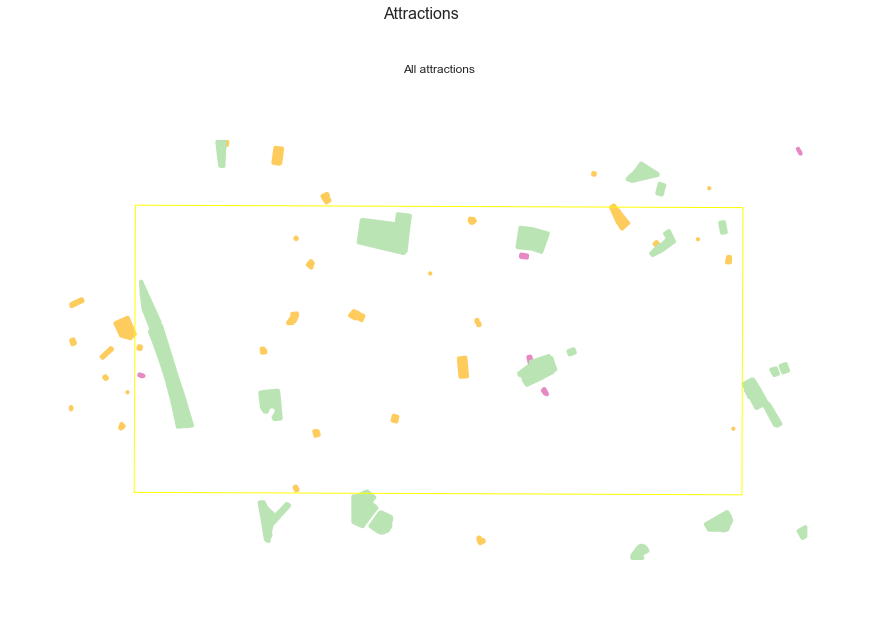

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
fig.suptitle('Attractions', fontsize=16)


barrier_width = 3

# all combined
playgrounds.set_geometry('geometry_buffer').plot(ax=axs, color='#fecc5c', linewidth=barrier_width, zorder=1)
schoolyards.set_geometry('geometry_buffer').plot(ax=axs, color='#e78ac3', linewidth=barrier_width, zorder=1)
parks_small.set_geometry('geometry_buffer').plot(ax=axs, color='#bae4b3', linewidth=barrier_width, zorder=1)
axs.set_title('All attractions')


place.plot(ax=axs, facecolor='none', edgecolor='yellow', linestyle='-', linewidth=1, zorder=1)

bbox = place.total_bounds
margin = 600
xlim = ([bbox[0]-margin, bbox[2]+margin])
ylim = ([bbox[1]-margin, bbox[3]+margin])
axs.set_xlim(xlim)
axs.set_ylim(ylim)
axs.axis('off')

    
plt.show()

#  Store output data

In [24]:
place_name_out = (place_name).split(',')[0].replace(' ', '')
today = datetime.date.today().strftime("%d%b%Y")
output_sub_folder = os.path.join(output_folder, '{}_{}'.format(place_name_out, today))

In [26]:
if not os.path.exists(output_sub_folder):
    os.mkdir(output_sub_folder)

In [27]:
output_file = os.path.join(output_sub_folder, 'playground_attraction.geojson')
playgrounds_out = playgrounds.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
playgrounds_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'schoolyard_attraction.geojson')
schoolyards_out = schoolyards.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
schoolyards_out.to_file(output_file, driver='GeoJSON')

output_file = os.path.join(output_sub_folder, 'small_park_attraction.geojson')
parks_small_out = parks_small.apply(lambda c: c.astype(str) if c.name != "geometry" else c, axis=0)
parks_small_out.to_file(output_file, driver='GeoJSON')